In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_URL = "https://raw.githubusercontent.com/marcopeix/FoundationModelsForTimeSeriesForecasting/refs/heads/main/data/Walmart.csv"

df = pd.read_csv(DATA_URL)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


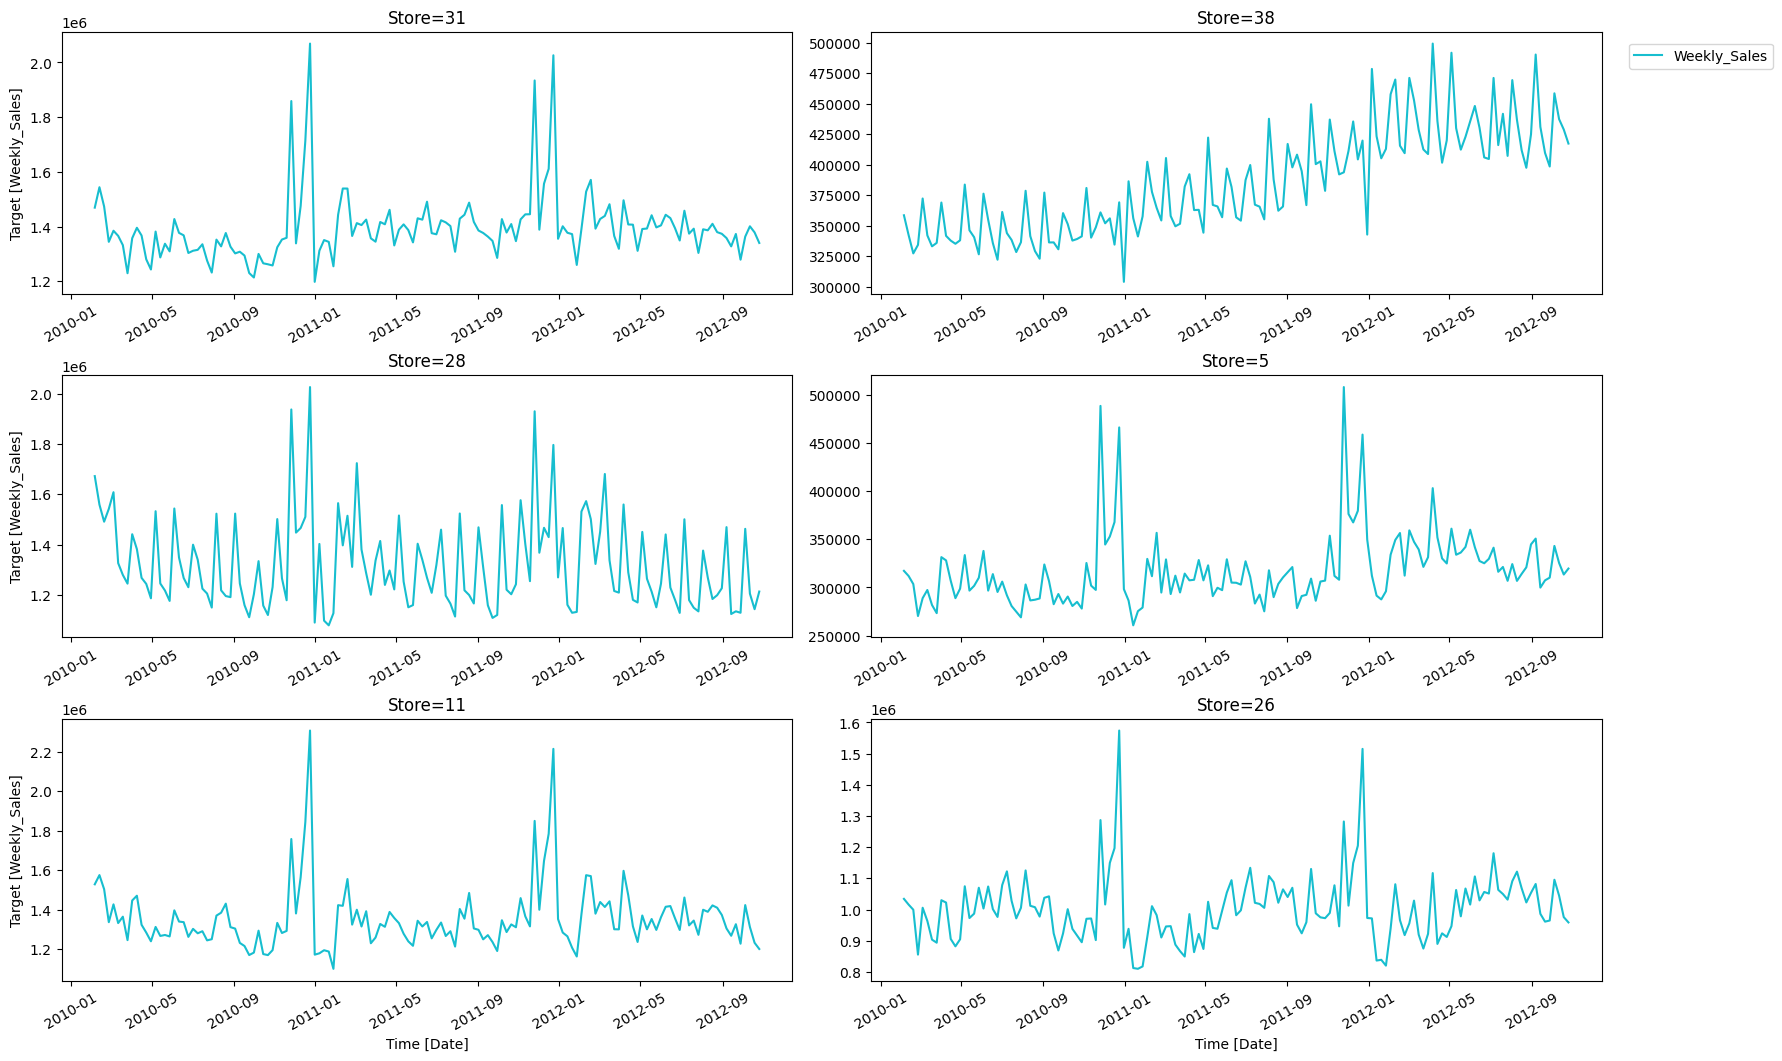

In [3]:
plot_series(df=df, id_col="Store", time_col="Date", target_col="Weekly_Sales", max_ids=6)

## Zero-shot forecasting

In [4]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [5]:
gluon_df = df.copy()
gluon_df = gluon_df.rename(columns={"Weekly_Sales": "target"})

ts_data = TimeSeriesDataFrame.from_data_frame(
    gluon_df[["Store", "Date", "target"]],
    id_column="Store",
    timestamp_column="Date",
)
display(ts_data.head())

target
item_id timestamp             
1       2010-02-05  1643690.90
        2010-02-12  1641957.44
        2010-02-19  1611968.17
        2010-02-26  1409727.59
        2010-03-05  1554806.68

In [6]:
HORIZON = 13

predictor = TimeSeriesPredictor(prediction_length=HORIZON).fit(
    ts_data, presets="bolt_small"
)

Beginning AutoGluon training...
AutoGluon will save models to 'D:\DataScienceWithMarco\FMFTSF\code\AutogluonModels\ag-20251130_153754'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          12
GPU Count:          0
Memory Avail:       9.05 GB / 15.92 GB (56.8%)
Disk Space Avail:   1473.73 GB / 2794.50 GB (52.7%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 13,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'W-FRI'
Provided train_data has 6435 rows, 

In [7]:
predictions = predictor.predict(ts_data)

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


In [8]:
preds_df = predictions.reset_index()

preds_df = preds_df.rename(columns={
    "item_id": "Store",
    "timestamp": "Date",
    "mean": "chronos-bolt-small",
    "0.1": "chronos-bolt-small-lo-80",
    "0.9": "chronos-bolt-small-hi-80"
})

preds_df = preds_df[["Store", "Date", "chronos-bolt-small", "chronos-bolt-small-lo-80", "chronos-bolt-small-hi-80"]]

preds_df.head()

,Store,Date,chronos-bolt-small,chronos-bolt-small-lo-80,chronos-bolt-small-hi-80
0,1,2012-11-02,1643704.625,1469773.000,1859272.375
1,1,2012-11-09,1723706.625,1527445.875,1986700.375
2,1,2012-11-16,1684980.125,1474449.375,1982145.375
3,1,2012-11-23,1691982.625,1451177.500,2023620.375
4,1,2012-11-30,1761792.375,1503337.000,2125016.000


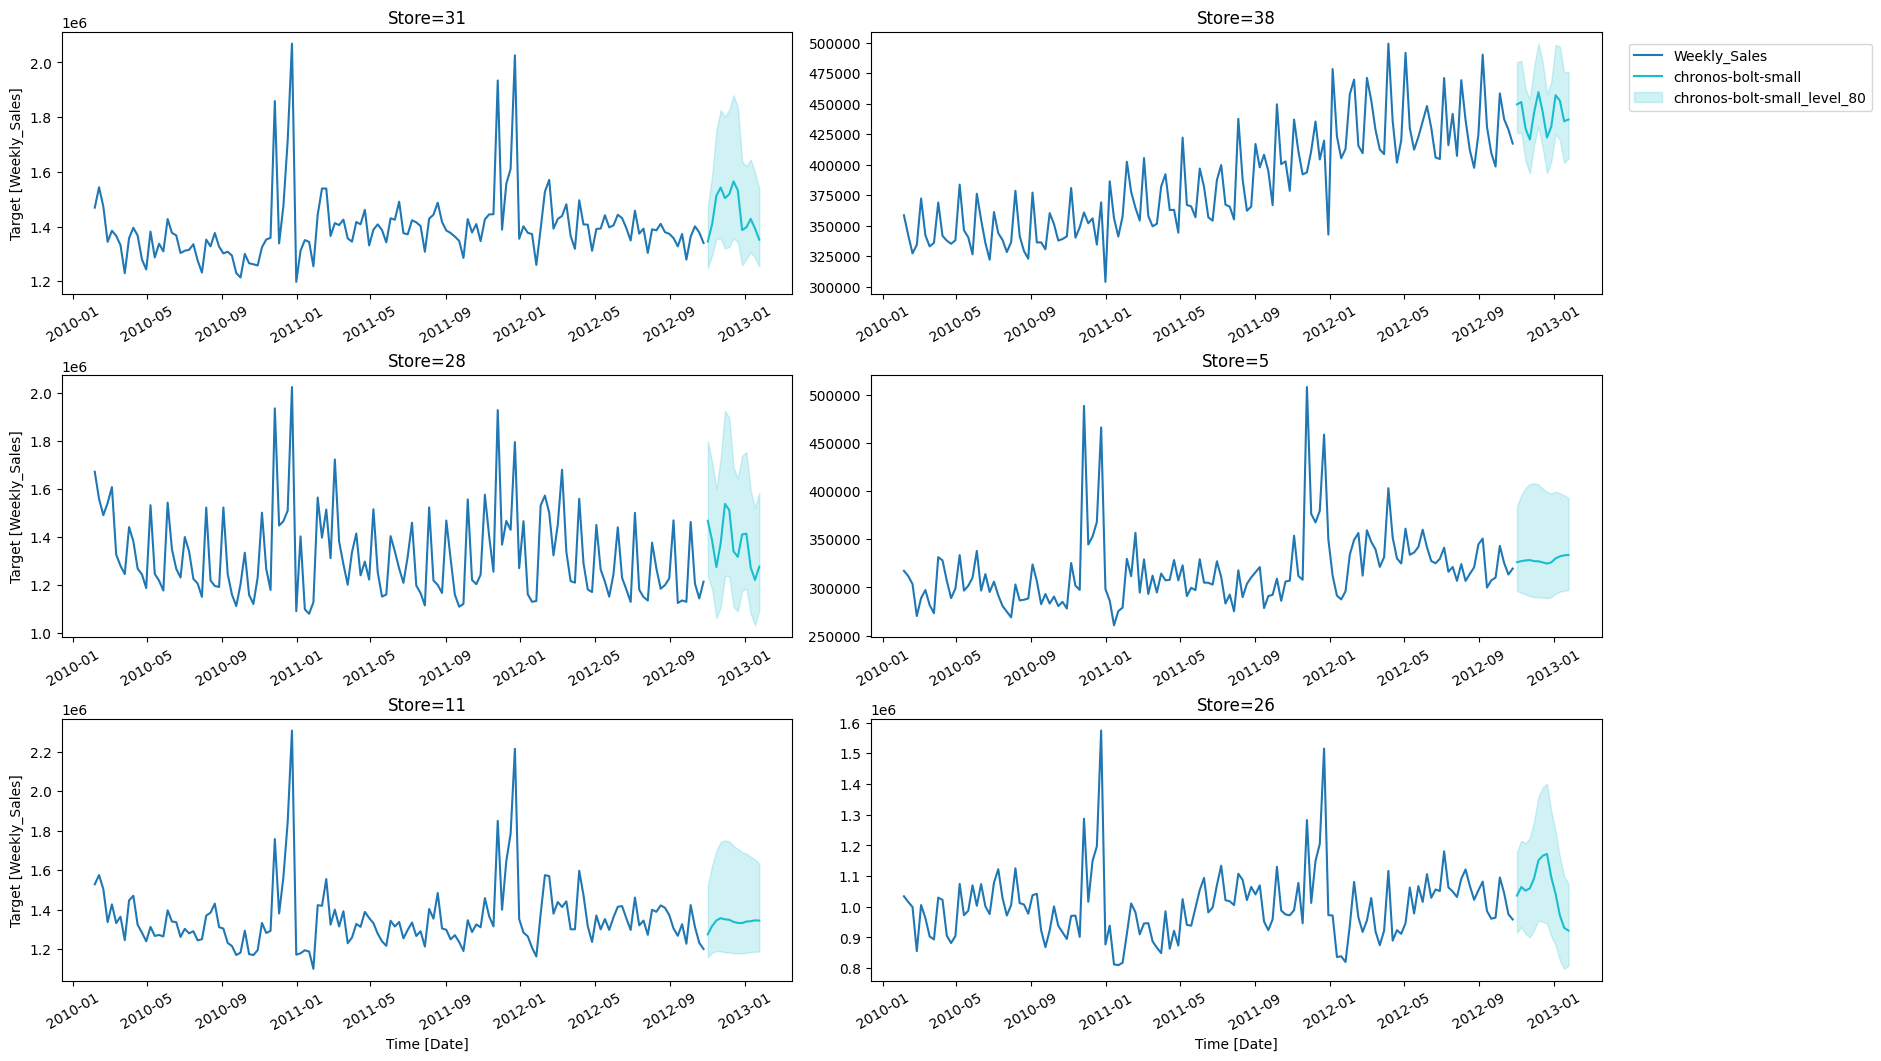

In [9]:
plot_series(
    df=df, 
    forecasts_df=preds_df,
    id_col="Store",
    time_col="Date", 
    target_col="Weekly_Sales",
    level=[80],
    max_ids=6,
)

## Cross-validation

In [10]:
def autogluon_cv(data, horizon, n_windows, step_size=None):
    if step_size is None:
        step_size = horizon

    predictor = TimeSeriesPredictor(prediction_length=horizon).fit(
        data, presets="bolt_small"
    )

    all_preds = []

    for i in range(n_windows):
        test_end_offset = horizon + (i * step_size)
        train, test = data.train_test_split(test_end_offset)
        
        preds = predictor.predict(train)
        preds_df = preds.reset_index()
        preds_df = preds_df.rename(columns={
            "item_id": "Store",
            "timestamp": "Date",
            "mean": "chronos-bolt-small",
            "0.1": "chronos-bolt-small-lo-80",
            "0.9": "chronos-bolt-small-hi-80"
        })

        test_df = test.reset_index()
        test_df = test_df.rename(columns={
            "item_id": "Store",
            "timestamp": "Date",
            "target": "Weekly_Sales"
        })
        preds_df = preds_df.merge(
            test_df[["Store", "Date", "Weekly_Sales"]],
            on=["Store", "Date"],
            how="left",
        )
        preds_df = preds_df[["Store", "Date", "Weekly_Sales", "chronos-bolt-small", "chronos-bolt-small-lo-80", "chronos-bolt-small-hi-80"]]

        all_preds.append(preds_df)

    all_preds_df = pd.concat(all_preds, ignore_index=True)

    return all_preds_df

In [11]:
cv_df = autogluon_cv(ts_data, horizon=HORIZON, n_windows=3)
cv_df.head()

Beginning AutoGluon training...
AutoGluon will save models to 'D:\DataScienceWithMarco\FMFTSF\code\AutogluonModels\ag-20251127_233451'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          12
GPU Count:          0
Memory Avail:       8.92 GB / 15.92 GB (56.0%)
Disk Space Avail:   1473.73 GB / 2794.50 GB (52.7%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 13,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'W-FRI'
Provided train_data has 6435 rows, 

,Store,Date,Weekly_Sales,chronos-bolt-small,chronos-bolt-small-lo-80,chronos-bolt-small-hi-80
0,1,2012-08-03,1631135.79,1600929.375,1496819.750,1744814.500
1,1,2012-08-10,1592409.97,1633665.750,1531835.875,1787428.875
2,1,2012-08-17,1597868.05,1578855.250,1467073.000,1734830.625
3,1,2012-08-24,1494122.38,1550252.875,1426059.000,1706471.375
4,1,2012-08-31,1582083.40,1619427.375,1491040.375,1797554.375


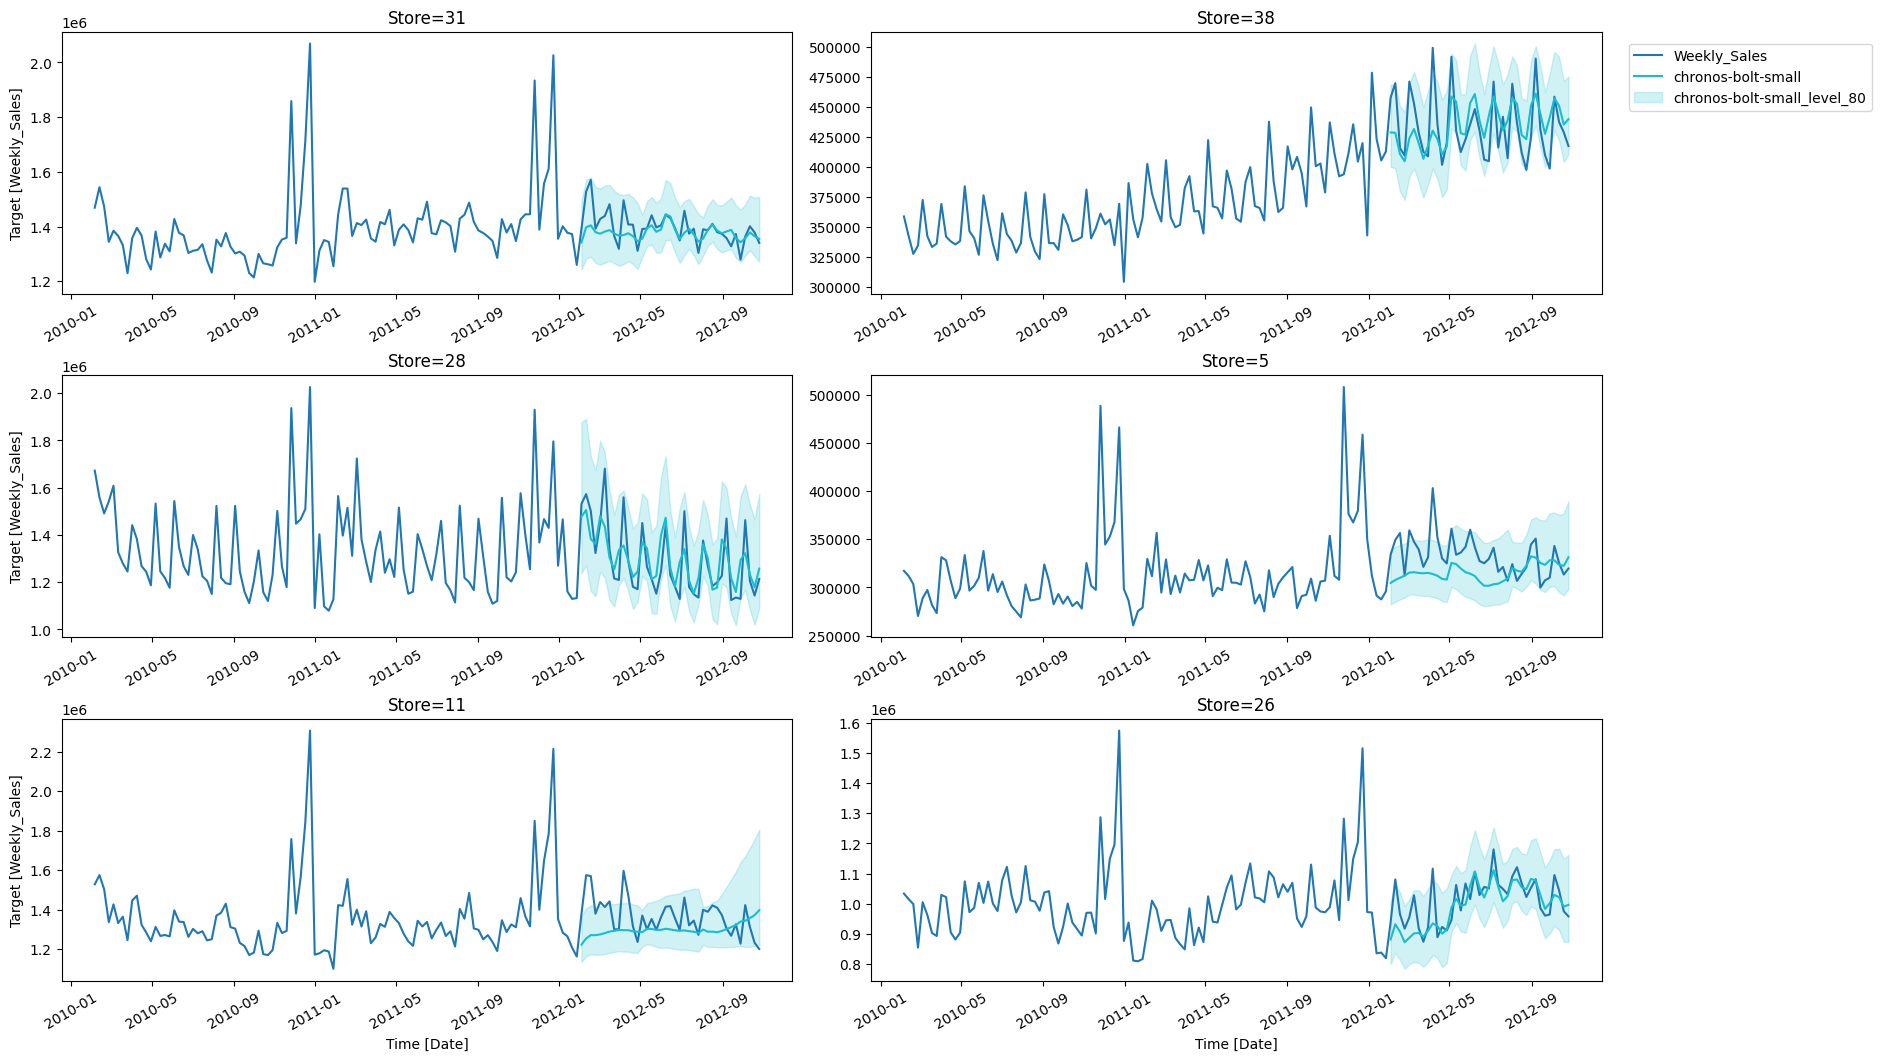

In [12]:
plot_series(
    df=df, 
    forecasts_df=cv_df.drop(columns=["Weekly_Sales"]),
    id_col="Store",
    time_col="Date", 
    target_col="Weekly_Sales",
    level=[80],
    max_ids=6,
)

In [13]:
eval_df = evaluate(
    pd.DataFrame(cv_df),
    metrics=[mae, smape],
    models=['chronos-bolt-small'],
    target_col='Weekly_Sales',
    id_col='Store',
    time_col="Date",
    agg_fn="mean"
)
eval_df.head()

,metric,chronos-bolt-small
0,mae,59104.808267
1,smape,0.028034


## Forecasting with covariates

In [7]:
gluon_df = df.copy()

ts_data_cov = TimeSeriesDataFrame.from_data_frame(
    gluon_df,
    id_column="Store",
    timestamp_column="Date",
)
display(ts_data_cov.head())

Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
item_id timestamp                                                         
1       2010-02-05    1643690.90             0        42.31       2.572   
        2010-02-12    1641957.44             1        38.51       2.548   
        2010-02-19    1611968.17             0        39.93       2.514   
        2010-02-26    1409727.59             0        46.63       2.561   
        2010-03-05    1554806.68             0        46.50       2.625   

                           CPI  Unemployment  
item_id timestamp                             
1       2010-02-05  211.096358         8.106  
        2010-02-12  211.242170         8.106  
        2010-02-19  211.289143         8.106  
        2010-02-26  211.319643         8.106  
        2010-03-05  211.350143         8.106

In [19]:
def autogluon_cv_exog(data, horizon, n_windows, step_size=None):
    if step_size is None:
        step_size = horizon

    all_preds = []

    for i in range(n_windows):
        test_end_offset = horizon + (i * step_size)
        train, test = data.train_test_split(test_end_offset)

        predictor = TimeSeriesPredictor(
            prediction_length=horizon, 
            target="Weekly_Sales",
            known_covariates_names=["Holiday_Flag"]
        ).fit(
            train, 
            presets="bolt_small",
            hyperparameters={
                "Chronos":[
                    {
                        "covariate_regressor": "XGB",
                        "target_scaler": "standard", # Optional in this case
                    }
                ]
            },
            enable_ensemble=False,
            time_limit=60,
        )
        
        preds = predictor.predict(train, known_covariates=test)
        preds_df = preds.reset_index()
        preds_df = preds_df.rename(columns={
            "item_id": "Store",
            "timestamp": "Date",
            "mean": "chronos-bolt-small",
            "0.1": "chronos-bolt-small-lo-80",
            "0.9": "chronos-bolt-small-hi-80"
        })

        test_df = test.reset_index()
        test_df = test_df.rename(columns={
            "item_id": "Store",
            "timestamp": "Date",
        })
        preds_df = preds_df.merge(
            test_df[["Store", "Date", "Weekly_Sales"]],
            on=["Store", "Date"],
            how="left",
        )
        preds_df = preds_df[["Store", "Date", "Weekly_Sales", "chronos-bolt-small", "chronos-bolt-small-lo-80", "chronos-bolt-small-hi-80"]]

        all_preds.append(preds_df)

    all_preds_df = pd.concat(all_preds, ignore_index=True)

    return all_preds_df

In [20]:
exog_cv_df = autogluon_cv_exog(ts_data_cov, horizon=HORIZON, n_windows=3)
exog_cv_df.head()

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to 'D:\DataScienceWithMarco\FMFTSF\code\AutogluonModels\ag-20251128_000255'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          12
GPU Count:          0
Memory Avail:       8.63 GB / 15.92 GB (54.2%)
Disk Space Avail:   1473.73 GB / 2794.50 GB (52.7%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'covariate_regressor': 'XGB',
                                  'target_scaler': 'standard'}]},
 'known_covariates_names': ['Holiday_Flag'],
 'num_val_windows': 1,
 'prediction_length': 13,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'Wee

,Store,Date,Weekly_Sales,chronos-bolt-small,chronos-bolt-small-lo-80,chronos-bolt-small-hi-80
0,1,2012-08-03,1631135.79,1.600013e+06,1.495779e+06,1.743856e+06
1,1,2012-08-10,1592409.97,1.632754e+06,1.530946e+06,1.786389e+06
2,1,2012-08-17,1597868.05,1.578769e+06,1.467110e+06,1.734626e+06
3,1,2012-08-24,1494122.38,1.550081e+06,1.426084e+06,1.706144e+06
4,1,2012-08-31,1582083.40,1.617983e+06,1.489931e+06,1.795705e+06


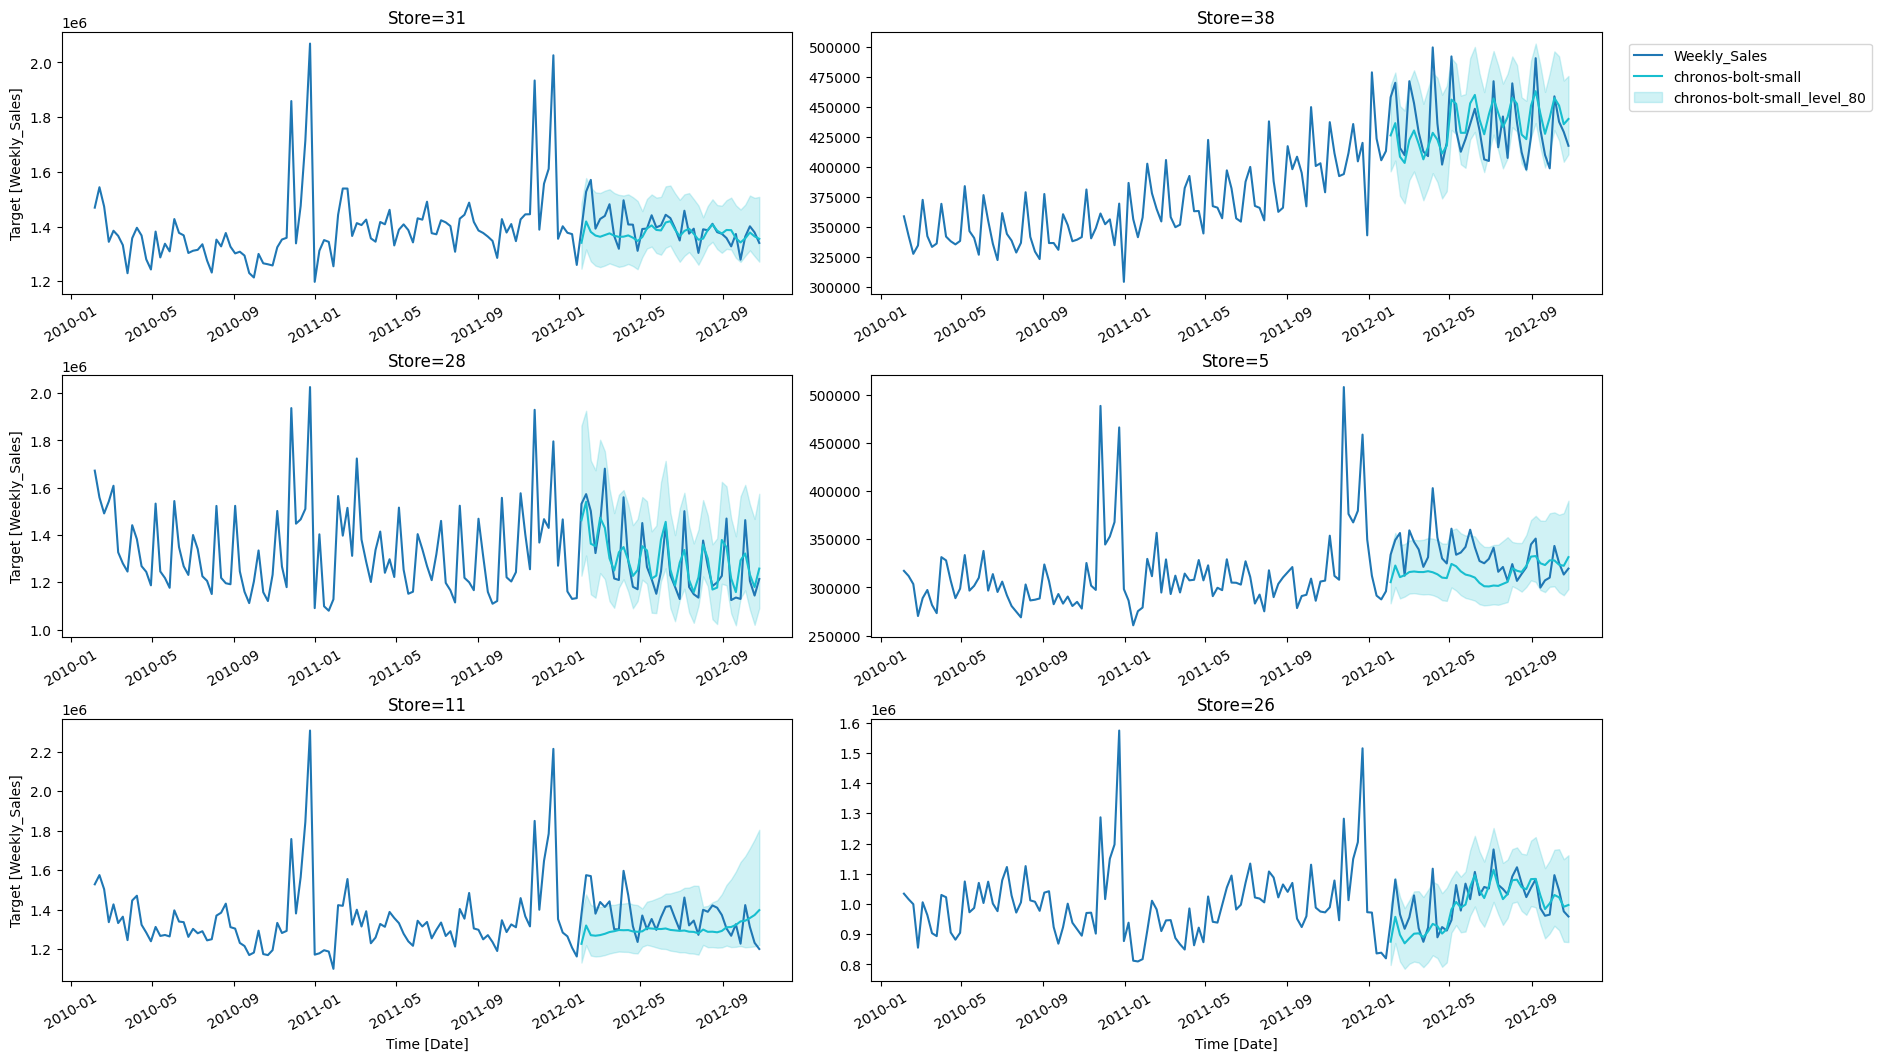

In [21]:
plot_series(
    df=df, 
    forecasts_df=exog_cv_df.drop(columns=["Weekly_Sales"]),
    id_col="Store",
    time_col="Date", 
    target_col="Weekly_Sales",
    level=[80],
    max_ids=6,
)

In [22]:
exog_eval_df = evaluate(
    pd.DataFrame(exog_cv_df),
    metrics=[mae, smape],
    models=['chronos-bolt-small'],
    target_col='Weekly_Sales',
    id_col='Store',
    time_col="Date",
    agg_fn="mean"
)
exog_eval_df.head()

,metric,chronos-bolt-small
0,mae,58198.007857
1,smape,0.027526


## Fine-tuning

In [8]:
def autogluon_cv_exog_finetune(data, horizon, n_windows, step_size=None, fine_tune=True):
    if step_size is None:
        step_size = horizon

    all_preds = []

    for i in range(n_windows):
        test_end_offset = horizon + (i * step_size)
        train, test = data.train_test_split(test_end_offset)

        predictor = TimeSeriesPredictor(
            prediction_length=horizon, 
            target="Weekly_Sales",
            known_covariates_names=["Holiday_Flag"]
        ).fit(
            train, 
            presets="bolt_small",
            hyperparameters={
                "Chronos":[
                    {
                        "covariate_regressor": "XGB",
                        "target_scaler": "standard", # Optional in this case
                        "fine_tune": fine_tune,
                        # Other fine-tuning parameters
                        # "fine_tune_lr": 1e-4,
                        # "fine_tune_steps": 100,
                    }
                ]
            },
            enable_ensemble=False,
            time_limit=120,
        )
        
        preds = predictor.predict(train, known_covariates=test)
        preds_df = preds.reset_index()
        preds_df = preds_df.rename(columns={
            "item_id": "Store",
            "timestamp": "Date",
            "mean": "chronos-bolt-small",
            "0.1": "chronos-bolt-small-lo-80",
            "0.9": "chronos-bolt-small-hi-80"
        })

        test_df = test.reset_index()
        test_df = test_df.rename(columns={
            "item_id": "Store",
            "timestamp": "Date",
        })
        preds_df = preds_df.merge(
            test_df[["Store", "Date", "Weekly_Sales"]],
            on=["Store", "Date"],
            how="left",
        )
        preds_df = preds_df[["Store", "Date", "Weekly_Sales", "chronos-bolt-small", "chronos-bolt-small-lo-80", "chronos-bolt-small-hi-80"]]

        all_preds.append(preds_df)

    all_preds_df = pd.concat(all_preds, ignore_index=True)

    return all_preds_df

In [10]:
ft_exog_cv_df = autogluon_cv_exog_finetune(ts_data_cov, horizon=HORIZON, n_windows=3)
ft_exog_cv_df.head()

Beginning AutoGluon training... Time limit = 120s
AutoGluon will save models to 'D:\DataScienceWithMarco\FMFTSF\code\AutogluonModels\ag-20251130_154421'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          12
GPU Count:          0
Memory Avail:       8.85 GB / 15.92 GB (55.6%)
Disk Space Avail:   1473.73 GB / 2794.50 GB (52.7%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'covariate_regressor': 'XGB',
                                  'fine_tune': True,
                                  'target_scaler': 'standard'}]},
 'known_covariates_names': ['Holiday_Flag'],
 'num_val_windows': 1,
 'prediction_length': 13,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full':

,Store,Date,Weekly_Sales,chronos-bolt-small,chronos-bolt-small-lo-80,chronos-bolt-small-hi-80
0,1,2012-08-03,1631135.79,1.600655e+06,1.532085e+06,1.704569e+06
1,1,2012-08-10,1592409.97,1.652528e+06,1.585187e+06,1.749620e+06
2,1,2012-08-17,1597868.05,1.594216e+06,1.524298e+06,1.693001e+06
3,1,2012-08-24,1494122.38,1.561776e+06,1.481343e+06,1.655800e+06
4,1,2012-08-31,1582083.40,1.631772e+06,1.548703e+06,1.729265e+06


In [11]:
ft_exog_eval_df = evaluate(
    pd.DataFrame(ft_exog_cv_df),
    metrics=[mae, smape],
    models=['chronos-bolt-small'],
    target_col='Weekly_Sales',
    id_col='Store',
    time_col="Date",
    agg_fn="mean"
)
ft_exog_eval_df.head()

,metric,chronos-bolt-small
0,mae,42361.058270
1,smape,0.020063
